In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from IPython.display import Image, display  

FVM 數值工具

In [2]:
def gradient_fd(f, dx):
    """一維中央差分梯度，邊界用 one-sided。"""
    grad = np.zeros_like(f)
    grad[1:-1] = (f[2:] - f[:-2]) / (2.0 * dx)
    grad[0] = (-3.0 * f[0] + 4.0 * f[1] - f[2]) / (2.0 * dx)
    grad[-1] = (3.0 * f[-1] - 4.0 * f[-2] + f[-3]) / (2.0 * dx)
    return grad


def build_u_center_and_u_face(rho, dx, D, rho_L, rho_R):
    """
    給 cell-centered rho (大小 NX)，建構:
      - u_center (cell-centered): u = -D * d/dx(log rho)
      - u_face   (face-centered): i+1/2, i=0..NX
    ghost cell 依據 Dirichlet rho_L, rho_R.
    """
    nx = rho.size
    rho_ext = np.empty(nx + 2)
    rho_ext[1:-1] = rho

    # ghost cells: Dirichlet ρ
    rho_ext[0] = rho_L
    rho_ext[-1] = rho_R

    log_rho_ext = np.log(np.clip(rho_ext, 1e-12, None))

    # cell-center velocity
    u_center = -D * (log_rho_ext[2:] - log_rho_ext[:-2]) / (2.0 * dx)

    # face velocity: 內部取平均，邊界用 one-sided 差分
    u_face = np.zeros(nx + 1)
    u_face[1:-1] = 0.5 * (u_center[:-1] + u_center[1:])
    u_face[0] = -D * 2.0 * (log_rho_ext[1] - log_rho_ext[0]) / dx
    u_face[-1] = -D * 2.0 * (log_rho_ext[-1] - log_rho_ext[-2]) / dx

    return u_center, u_face


def upwind_flux(q_L, q_R, u_face):
    """單純 upwind scalar flux。"""
    return u_face * (q_L if u_face > 0.0 else q_R)

 $I, K, R$ 三個變量的更新步驟

In [3]:
def solve_fvm_I(I_n, u_face, dx, dt):
    nx = len(I_n)
    I_next = I_n.copy()
    flux = np.zeros(nx + 1)

    for j in range(1, nx):
        flux[j] = upwind_flux(I_n[j - 1], I_n[j], u_face[j])

    I_next[1:-1] = I_n[1:-1] - (dt / dx) * (flux[2:-1] - flux[1:-2])
    return I_next


def solve_fvm_K(K_n, u_face, grad_u, dx, dt):
    """
    K_t + div(u K) = K * div u
    在 1D：K_t + (uK)_x = K * u_x
    """
    nx = len(K_n)
    K_next = K_n.copy()
    flux = np.zeros(nx + 1)

    for j in range(1, nx):
        flux[j] = upwind_flux(K_n[j - 1], K_n[j], u_face[j])

    advec = -(dt / dx) * (flux[2:-1] - flux[1:-2])
    source = dt * (K_n * grad_u)[1:-1]
    K_next[1:-1] = K_n[1:-1] + advec + source
    return K_next


def solve_fvm_R(R_n, u_face, grad_u, r_over_I, dx, dt):
    """
    R_t + div(u R) = R * div u + r(ρ)/I
    """
    nx = len(R_n)
    R_next = R_n.copy()
    flux = np.zeros(nx + 1)

    for j in range(1, nx):
        flux[j] = upwind_flux(R_n[j - 1], R_n[j], u_face[j])

    advec = -(dt / dx) * (flux[2:-1] - flux[1:-2])
    source = dt * ((R_n * grad_u)[1:-1] + r_over_I[1:-1])
    R_next[1:-1] = R_n[1:-1] + advec + source
    return R_next

In [4]:
def fkpp_exact(x, t, D, x0=0.0):
    """
    Fisher–KPP: ρ_t = D ρ_xx + ρ - ρ^2
    A-Z 型 traveling wave 精確解。
    """
    c = 5.0 * np.sqrt(D / 6.0)
    L = np.sqrt(6.0 * D)
    z = (x - c * t - x0) / L
    return 1.0 / (1.0 + np.exp(z))**2


def run_simulation(D=1.0, X_MIN=-10.0, X_MAX=20.0,
                   T_MAX=10.0, NX=201, NT=1601, x0_wave=0.0):
    DX = (X_MAX - X_MIN) / NX
    DT = T_MAX / (NT - 1)

    # cell centers
    x = X_MIN + (np.arange(NX) + 0.5) * DX

    # 初始條件：exact traveling wave
    rho0 = fkpp_exact(x, 0.0, D, x0_wave)

    # 分解: ρ = (K+R)I, 這裡一開始 I=1, R=0, K=ρ0
    I_current = np.ones_like(rho0)
    K_current = rho0.copy()
    R_current = np.zeros_like(rho0)
    rho_current = rho0.copy()

    rho_history = np.zeros((NT, NX))
    rho_history[0] = rho_current.copy()
    time_steps = np.linspace(0.0, T_MAX, NT)

    for n in range(1, NT):
        t_n = time_steps[n - 1]
        t_np1 = time_steps[n]

        # 邊界 Dirichlet (用在 ghost cell)
        rho_L = fkpp_exact(X_MIN, t_n, D, x0_wave)
        rho_R = fkpp_exact(X_MAX, t_n, D, x0_wave)

        # 由ρ建構 u
        u_center, u_face = build_u_center_and_u_face(
            rho_current, DX, D, rho_L, rho_R
        )

        # 簡單 CFL：限制 |u| <= DX/DT
        max_vel = DX / DT
        u_center = np.clip(u_center, -max_vel, max_vel)
        u_face = np.clip(u_face, -max_vel, max_vel)

        grad_u = gradient_fd(u_center, DX)

        # 反應項 r(ρ) = ρ - ρ^2
        r = rho_current - rho_current**2
        r_over_I = r / np.clip(I_current, 1e-12, None)

        # FVM step（只更新 interior)
        I_next = solve_fvm_I(I_current, u_face, DX, DT)
        K_next = solve_fvm_K(K_current, u_face, grad_u, DX, DT)
        R_next = solve_fvm_R(R_current, u_face, grad_u, r_over_I, DX, DT)

        # 重建 ρ
        rho_next = (K_next + R_next) * I_next

        # ---- 關鍵修正：在 t_{n+1} 強制 Dirichlet ρ，並讓 (K,R,I) 一致 ----
        rho_L_np1 = fkpp_exact(X_MIN, t_np1, D, x0_wave)
        rho_R_np1 = fkpp_exact(X_MAX, t_np1, D, x0_wave)
        rho_next[0] = rho_L_np1
        rho_next[-1] = rho_R_np1

        # 最簡單的配法：I=1, R=0, K=ρ 在邊界
        I_next[0] = 1.0
        I_next[-1] = 1.0
        R_next[0] = 0.0
        R_next[-1] = 0.0
        K_next[0] = rho_L_np1
        K_next[-1] = rho_R_np1
        # -------------------------------------------------------------

        # 數值噪聲剪掉
        rho_next = np.clip(rho_next, 1e-12, 1.0)

        rho_history[n] = rho_next.copy()
        I_current, K_current, R_current = I_next, K_next, R_next
        rho_current = rho_next

    return x, rho_history, time_steps

視覺化

In [5]:
def plot_results(x, rho_numerical_history, rho_exact_history, time_steps,
                 X_MIN=-10.0, X_MAX=20.0, output_dir="results_FKPP_KRI"):
    """
    視覺化：
      - 主動畫：數值解 vs 精確解，顯示 t & MSE
      - 誤差動畫：pointwise squared error vs x
    """
    os.makedirs(output_dir, exist_ok=True)

    # --- 主動畫：解本身 ---
    fig, ax = plt.subplots(figsize=(10, 6))
    line_num, = ax.plot([], [], "r--", label="Numerical (FVM Upwind, K+R,I)")
    line_ex,  = ax.plot([], [], "g:", lw=3, label="Exact (A–Z Wave)")

    time_text = ax.text(0.05, 0.9, "", transform=ax.transAxes)
    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlabel("x")
    ax.set_ylabel(r"$\rho(x,t)$")
    ax.set_title("1D Fisher–KPP: ρ = (K+R)I (FVM Upwind) vs Exact")
    ax.legend()
    ax.grid(True)

    squared_error_history = (rho_numerical_history - rho_exact_history)**2
    mse_history = np.mean(squared_error_history, axis=1)
    print(f"Maximum MSE across all time points: {np.max(mse_history):.6e}")

    # 抽 frame，避免 gif 過大
    frame_indices = list(range(0, len(time_steps), 20))
    if frame_indices[-1] != len(time_steps) - 1:
        frame_indices.append(len(time_steps) - 1)

    def update(k):
        n = frame_indices[k]
        rho_num = rho_numerical_history[n]
        rho_ex = rho_exact_history[n]
        mse = np.mean((rho_num - rho_ex)**2)

        line_num.set_data(x, rho_num)
        line_ex.set_data(x, rho_ex)
        time_text.set_text(f"t = {time_steps[n]:.2f} s\nMSE = {mse:.2e}")
        return line_num, line_ex, time_text

    anim = FuncAnimation(fig, update, frames=len(frame_indices),
                         interval=40, blit=True)
    writer = PillowWriter(fps=25)
    
    sim_path = os.path.join(output_dir, "simulation.gif")
    anim.save(sim_path, writer=writer)
    print(f"Saved {sim_path}")

    # --- 第二個動畫：pointwise squared error ---
    fig_err, ax_err = plt.subplots(figsize=(10, 6))
    line_err, = ax_err.plot([], [], "b-", label="Squared Error")
    err_text = ax_err.text(0.05, 0.9, "", transform=ax_err.transAxes)

    ax_err.set_xlim(X_MIN, X_MAX)
    max_err = np.max(squared_error_history)
    ax_err.set_ylim(0.0, max_err * 1.1 if max_err > 0 else 1.0)
    ax_err.set_xlabel("x")
    ax_err.set_ylabel("Squared Error")
    ax_err.set_title("Pointwise Squared Error Over Time")
    ax_err.legend()
    ax_err.grid(True)

    def update_err(k):
        n = frame_indices[k]
        line_err.set_data(x, squared_error_history[n])
        err_text.set_text(
            f"t = {time_steps[n]:.2f} s\nMSE = {mse_history[n]:.2e}"
        )
        return line_err, err_text

    anim_err = FuncAnimation(fig_err, update_err, frames=len(frame_indices),
                             interval=40, blit=True)
    
    mse_path = os.path.join(output_dir, "mse.gif")
    anim_err.save(mse_path, writer=writer)
    print(f"Saved {mse_path}")
    
    plt.close('all') # 避免在輸出區重複顯示靜態圖
    return sim_path, mse_path

開始執行模擬...
Maximum MSE across all time points: 9.789731e-05
Saved results_KIR_dirichlet\simulation.gif
Saved results_KIR_dirichlet\mse.gif
模擬完成。以下顯示結果：
1. Simulation (Numerical vs Exact):


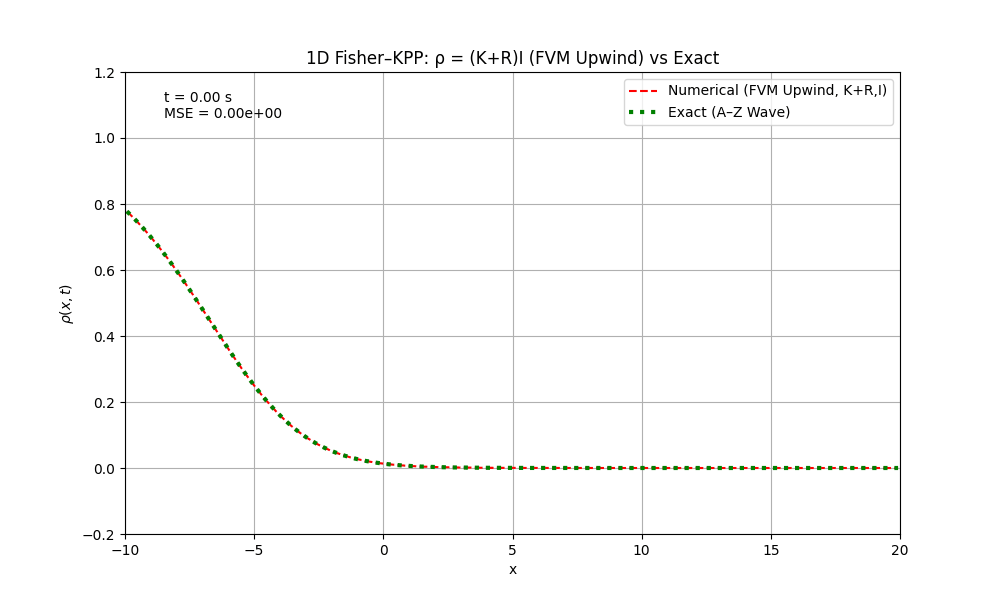


2. Pointwise Squared Error:


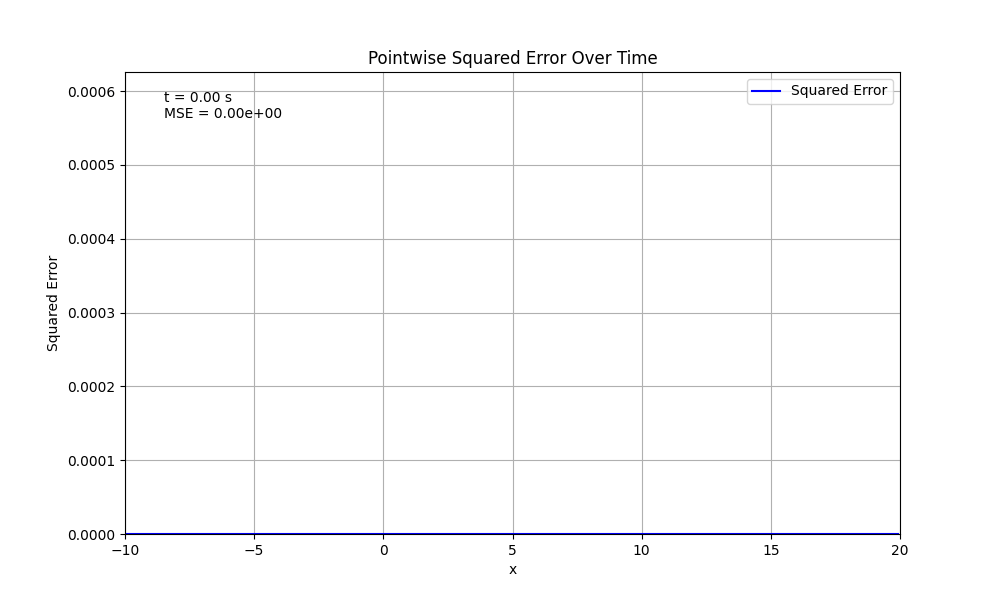

In [6]:
# 參數設定
D = 1.0
X_MIN, X_MAX = -10.0, 20.0
T_MAX = 10.0
NX, NT = 201, 1601
x0_wave = -5.0

print("開始執行模擬...")

# 執行計算
x, rho_numerical_history, time_steps = run_simulation(
    D=D, X_MIN=X_MIN, X_MAX=X_MAX,
    T_MAX=T_MAX, NX=NX, NT=NT, x0_wave=x0_wave
)

# 計算精確解以供比較
rho_exact_history = np.array([
    fkpp_exact(x, t, D, x0_wave) for t in time_steps
])

# 繪圖並儲存
output_dir = "results_KIR_dirichlet"
sim_gif, mse_gif = plot_results(
    x, rho_numerical_history, rho_exact_history,
    time_steps, X_MIN, X_MAX, output_dir
)

print("模擬完成。以下顯示結果：")

# 在 Colab 中直接顯示 GIF
print("1. Simulation (Numerical vs Exact):")
display(Image(filename=sim_gif))

print("\n2. Pointwise Squared Error:")
display(Image(filename=mse_gif))